In [22]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import time

In [23]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    # Use c = y to color each point
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    #plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)
    
def plot_model2(X, y, model, r2 = 5, step = 10):
    """
    Plot the subdomain partition predicted by the neuaral network
    """
    model.cpu()
    mesh = np.arange(-r2 -0.5, r2 + 0.5, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    # Plot the sample points of each subdomain
    # plt.scatter(X.numpy()[:-1:step, 0], X.numpy()[:-1:step, 1], c=y[:-1:step], s=20, cmap=plt.cm.Spectral)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.title('Predicted domain partiton')

In [24]:
set_default()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

# Input parameters.
N = 500  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 4  # number of sub-classes
H1 = 20  # number of neuros of the first hidden layer
H2 = 10  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
H4 = 10 # number of neuros of the fourth hidden layer
noice = 0.2 # noice rate

# Allocation of the memories 
#  X: a 2D array for the matrix of order NC x D
#  y: a 1D array for the vector of order NC
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

# Generate a uniform partition of interval [0, 1] for parameter variable t
#  t_j = j/N for j=0, 1, 2, ..., N
t = torch.linspace(0, 1, N)

# Length of each subinterval 
tau = 2 * math.pi / C

In [26]:
for i in range(C):  # Here i = 0, 1, 2, ..., C-1
    j = 0
    # Generate N numbers in the subinterval [tau*i, tau*(i+1)] with tau = 2pi/C
    theta = torch.linspace(tau * i, tau * (i + 1), N) + torch.randn(N) * noice
    # Generate the N sample points in the $i$th subdomain D_i
    for ix in range(N * i, N * (i + 1)):
        X[ix] = t[j] * torch.FloatTensor((
            math.sin(theta[j]), math.cos(theta[j])
        ))
        y[ix] = i
        j += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))
#print('y=', y)
#print('X=', X)

Shapes:
X: (2000, 2)
y: (2000,)


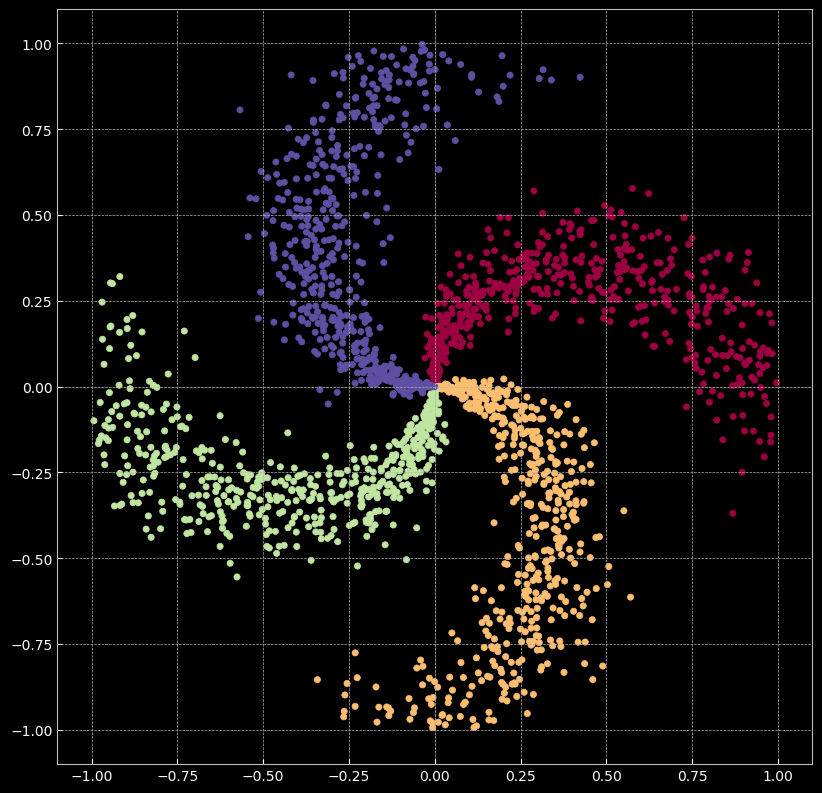

In [27]:
plot_data(X, y)

In [28]:
one_hot = torch.nn.functional.one_hot(y)
one_hot = one_hot.to(torch.float32)

In [29]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [30]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        
    def forward(self, output, target):
        
        loss = torch.mean((output - target)**2)
        return loss

In [31]:
class crossentropy(nn.Module): 
    def __init__(self,m=0): 
        super(crossentropy, self).__init__() 
        self.m = m 
    def forward(self, y_1, y):
        m = self.m 
        m = nn.LogSoftmax() 
        output = m(y_1) 
        loss = -1.0*torch.sum(y*output) 
        l = torch.mean(loss) 
        return l 

# NN with custom MSE

In [32]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model = nn.Sequential(
    nn.Linear(D, H1),
    nn.ReLU(),
    nn.Linear(H1, H2),
    nn.ReLU(),
    nn.Linear(H2, H3),
    nn.ReLU(),
    nn.Linear(H3, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = MSE()
#Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, one_hot)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")# nn package to create our linear model


[EPOCH]: 0, [LOSS]: 0.350160, [ACCURACY]: 0.250
[EPOCH]: 1, [LOSS]: 0.276353, [ACCURACY]: 0.306
[EPOCH]: 2, [LOSS]: 0.224266, [ACCURACY]: 0.250
[EPOCH]: 3, [LOSS]: 0.174396, [ACCURACY]: 0.484
[EPOCH]: 4, [LOSS]: 0.205025, [ACCURACY]: 0.314
[EPOCH]: 5, [LOSS]: 0.162615, [ACCURACY]: 0.525
[EPOCH]: 6, [LOSS]: 0.155239, [ACCURACY]: 0.535
[EPOCH]: 7, [LOSS]: 0.149343, [ACCURACY]: 0.714
[EPOCH]: 8, [LOSS]: 0.130359, [ACCURACY]: 0.834
[EPOCH]: 9, [LOSS]: 0.113219, [ACCURACY]: 0.802
[EPOCH]: 10, [LOSS]: 0.113471, [ACCURACY]: 0.763
[EPOCH]: 11, [LOSS]: 0.102987, [ACCURACY]: 0.818
[EPOCH]: 12, [LOSS]: 0.089790, [ACCURACY]: 0.873
[EPOCH]: 13, [LOSS]: 0.083424, [ACCURACY]: 0.874
[EPOCH]: 14, [LOSS]: 0.078931, [ACCURACY]: 0.868
[EPOCH]: 15, [LOSS]: 0.070436, [ACCURACY]: 0.890
[EPOCH]: 16, [LOSS]: 0.060853, [ACCURACY]: 0.911
[EPOCH]: 17, [LOSS]: 0.054186, [ACCURACY]: 0.934
[EPOCH]: 18, [LOSS]: 0.052494, [ACCURACY]: 0.911
[EPOCH]: 19, [LOSS]: 0.050347, [ACCURACY]: 0.919
[EPOCH]: 20, [LOSS]: 0.044937,

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=4, bias=True)
)


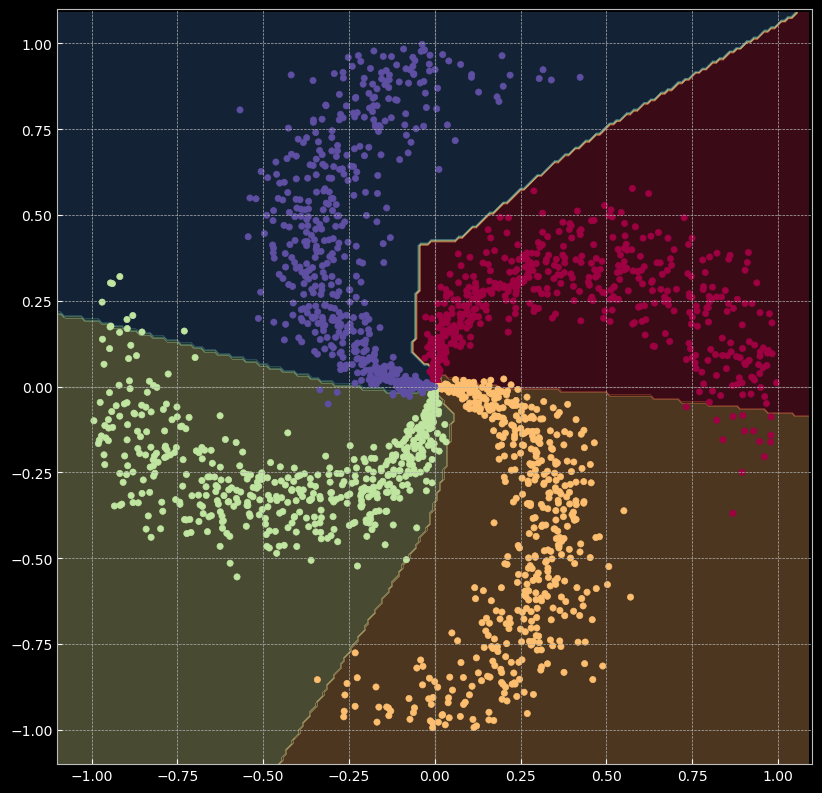

In [33]:
print(model)
plot_model(X, y, model)

# NN with custom cross entropy loss

In [34]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model = nn.Sequential(
    nn.Linear(D, H1),
    nn.ReLU(),
    nn.Linear(H1, H2),
    nn.ReLU(),
    nn.Linear(H2, H3),
    nn.ReLU(),
    nn.Linear(H3, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = crossentropy()
#Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, one_hot)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")# nn package to create our linear model


C:\Users\abhil\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


[EPOCH]: 0, [LOSS]: 2810.279297, [ACCURACY]: 0.250
[EPOCH]: 1, [LOSS]: 2801.627441, [ACCURACY]: 0.250
[EPOCH]: 2, [LOSS]: 2754.707764, [ACCURACY]: 0.250
[EPOCH]: 3, [LOSS]: 2611.043945, [ACCURACY]: 0.417
[EPOCH]: 4, [LOSS]: 2519.408447, [ACCURACY]: 0.354
[EPOCH]: 5, [LOSS]: 2271.628906, [ACCURACY]: 0.474
[EPOCH]: 6, [LOSS]: 2033.147217, [ACCURACY]: 0.500
[EPOCH]: 7, [LOSS]: 1799.549316, [ACCURACY]: 0.562
[EPOCH]: 8, [LOSS]: 1743.170898, [ACCURACY]: 0.486
[EPOCH]: 9, [LOSS]: 1707.194336, [ACCURACY]: 0.480
[EPOCH]: 10, [LOSS]: 1673.226196, [ACCURACY]: 0.573
[EPOCH]: 11, [LOSS]: 1623.117920, [ACCURACY]: 0.700
[EPOCH]: 12, [LOSS]: 1407.009644, [ACCURACY]: 0.651
[EPOCH]: 13, [LOSS]: 1435.175659, [ACCURACY]: 0.536
[EPOCH]: 14, [LOSS]: 1165.818726, [ACCURACY]: 0.734
[EPOCH]: 15, [LOSS]: 1075.424683, [ACCURACY]: 0.794
[EPOCH]: 16, [LOSS]: 965.893066, [ACCURACY]: 0.863
[EPOCH]: 17, [LOSS]: 784.215698, [ACCURACY]: 0.908
[EPOCH]: 18, [LOSS]: 702.317688, [ACCURACY]: 0.892
[EPOCH]: 19, [LOSS]: 644.

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=4, bias=True)
)


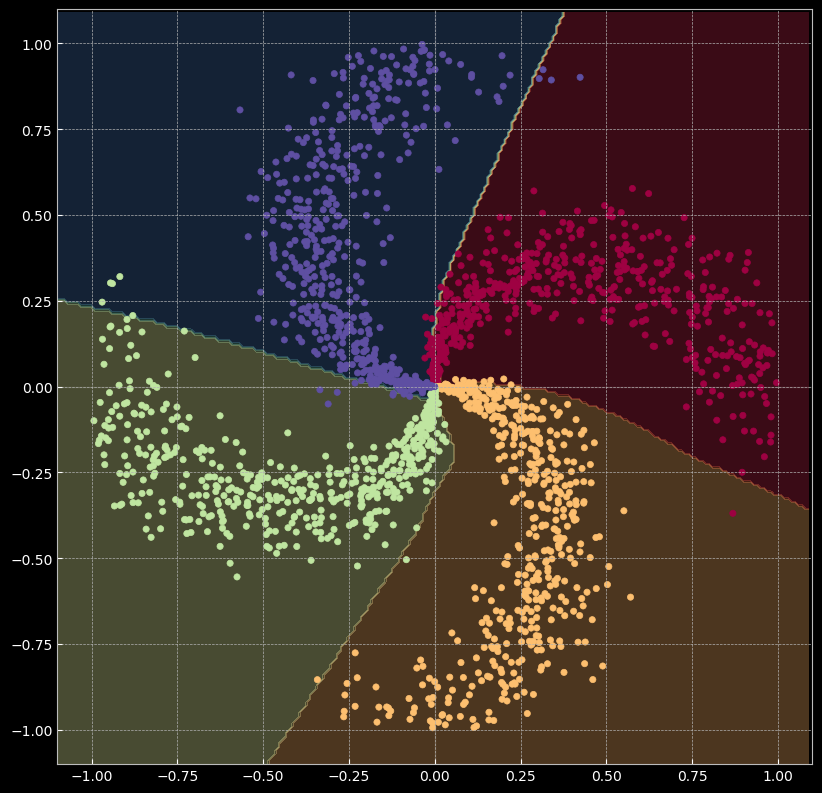

In [35]:
print(model)
plot_model(X, y, model)

# mRelu

In [36]:
class mReLU(nn.Module):
# Define mReLU as a subclass of nn.Module.  Here h is a given parameter.   

    def __init__(self, h=0.5): 
        super(mReLU, self).__init__()
        self.h = h

    def forward(self, x):
        h=self.h
        y = torch.zeros(x.shape)
        z = torch.where(x>h, x, torch.where(x<-h, y, 1/(4*h)*x*x + 1/2*x + 1/4*h))
        return z

In [39]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved.

activation_function = mReLU()
model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function ,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = MSE()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, one_hot)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 0.349676, [ACCURACY]: 0.250
[EPOCH]: 1, [LOSS]: 0.377937, [ACCURACY]: 0.250
[EPOCH]: 2, [LOSS]: 0.206881, [ACCURACY]: 0.250
[EPOCH]: 3, [LOSS]: 0.194694, [ACCURACY]: 0.250
[EPOCH]: 4, [LOSS]: 0.191822, [ACCURACY]: 0.250
[EPOCH]: 5, [LOSS]: 0.196340, [ACCURACY]: 0.250
[EPOCH]: 6, [LOSS]: 0.201486, [ACCURACY]: 0.289
[EPOCH]: 7, [LOSS]: 0.201411, [ACCURACY]: 0.421
[EPOCH]: 8, [LOSS]: 0.195536, [ACCURACY]: 0.368
[EPOCH]: 9, [LOSS]: 0.187194, [ACCURACY]: 0.368
[EPOCH]: 10, [LOSS]: 0.177615, [ACCURACY]: 0.383
[EPOCH]: 11, [LOSS]: 0.171822, [ACCURACY]: 0.396
[EPOCH]: 12, [LOSS]: 0.166204, [ACCURACY]: 0.390
[EPOCH]: 13, [LOSS]: 0.164666, [ACCURACY]: 0.377
[EPOCH]: 14, [LOSS]: 0.164561, [ACCURACY]: 0.417
[EPOCH]: 15, [LOSS]: 0.164886, [ACCURACY]: 0.417
[EPOCH]: 16, [LOSS]: 0.164031, [ACCURACY]: 0.417
[EPOCH]: 17, [LOSS]: 0.162208, [ACCURACY]: 0.412
[EPOCH]: 18, [LOSS]: 0.160136, [ACCURACY]: 0.415
[EPOCH]: 19, [LOSS]: 0.157812, [ACCURACY]: 0.419
[EPOCH]: 20, [LOSS]: 0.155864,

In [40]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved.

activation_function = mReLU()
model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function ,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = crossentropy()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, one_hot)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

C:\Users\abhil\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


[EPOCH]: 0, [LOSS]: 2768.662109, [ACCURACY]: 0.236
[EPOCH]: 1, [LOSS]: 2673.793213, [ACCURACY]: 0.350
[EPOCH]: 2, [LOSS]: 2274.704102, [ACCURACY]: 0.473
[EPOCH]: 3, [LOSS]: 1839.907715, [ACCURACY]: 0.559
[EPOCH]: 4, [LOSS]: 1576.745483, [ACCURACY]: 0.686
[EPOCH]: 5, [LOSS]: 2298.279785, [ACCURACY]: 0.524
[EPOCH]: 6, [LOSS]: 1057.867676, [ACCURACY]: 0.720
[EPOCH]: 7, [LOSS]: 1374.240479, [ACCURACY]: 0.755
[EPOCH]: 8, [LOSS]: 927.741943, [ACCURACY]: 0.813
[EPOCH]: 9, [LOSS]: 738.386475, [ACCURACY]: 0.826
[EPOCH]: 10, [LOSS]: 759.969788, [ACCURACY]: 0.832
[EPOCH]: 11, [LOSS]: 764.306030, [ACCURACY]: 0.848
[EPOCH]: 12, [LOSS]: 607.779053, [ACCURACY]: 0.882
[EPOCH]: 13, [LOSS]: 504.276001, [ACCURACY]: 0.913
[EPOCH]: 14, [LOSS]: 575.910645, [ACCURACY]: 0.905
[EPOCH]: 15, [LOSS]: 477.951965, [ACCURACY]: 0.933
[EPOCH]: 16, [LOSS]: 422.272949, [ACCURACY]: 0.927
[EPOCH]: 17, [LOSS]: 394.253296, [ACCURACY]: 0.925
[EPOCH]: 18, [LOSS]: 347.541656, [ACCURACY]: 0.932
[EPOCH]: 19, [LOSS]: 367.245972, 